In [18]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder


In [19]:
df = pd.read_csv('co2_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

In [20]:
df.describe()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
count,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000
mean,3.160068,5.615030,12.556534,9.041706,10.975071,27.481652,250.584699
std,1.354170,1.828307,3.500274,2.224456,2.892506,7.231879,58.512679
min,0.900000,3.000000,4.200000,4.000000,4.100000,11.000000,96.000000
25%,2.000000,4.000000,10.100000,7.500000,8.900000,22.000000,208.000000
50%,3.000000,6.000000,12.100000,8.700000,10.600000,27.000000,246.000000
75%,3.700000,6.000000,14.600000,10.200000,12.600000,32.000000,288.000000
max,8.400000,16.000000,30.600000,20.600000,26.100000,69.000000,522.000000


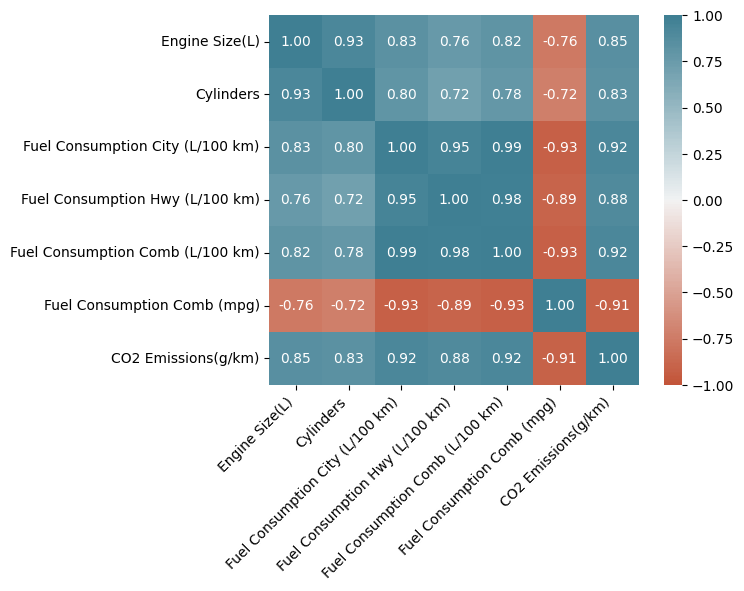

In [26]:
numeric_features = df.select_dtypes(exclude=['object'])
corr = numeric_features.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True,
    fmt='.2f',
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [35]:
corr_dict = {col : df['CO2 Emissions(g/km)'].corr(df[col]) for col in numeric_features.columns}
for k,v in sorted(corr_dict.items(), key=lambda x: x[1], reverse=True):
    print(f'{k}: {v}',"\n")

CO2 Emissions(g/km): 0.9999999999999999 

Fuel Consumption City (L/100 km): 0.9195924749024846 

Fuel Consumption Comb (L/100 km): 0.9180515723870845 

Fuel Consumption Hwy (L/100 km): 0.8835359454649436 

Engine Size(L): 0.8511446437900011 

Cylinders: 0.8326436002237771 

Fuel Consumption Comb (mpg): -0.9074262866541869 



The negative correlation between Fuel Consumption Comb (mpg) and CO2 Emissions(g/km) shows strong they move in opposite directions. These could be because of using different Units for measurement.

In [37]:
conversion_factor = 235.214

df["Fuel Consumption Comb (L/100 km)"] = conversion_factor/df["Fuel Consumption Comb (mpg)"]
print(df["CO2 Emissions(g/km)"].corr(df["Fuel Consumption Comb (L/100 km)"]))

0.9176255518074707


After unit conversion we see that the problem got fixed. Now we can use this new feature.

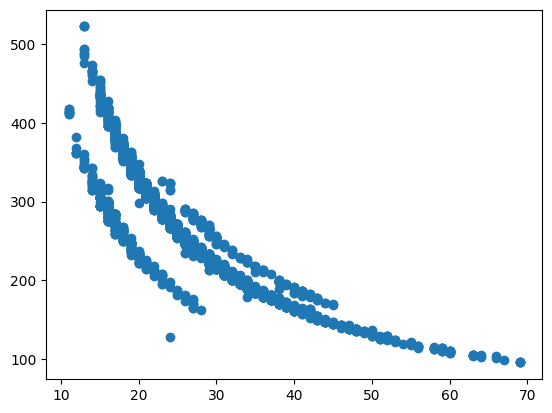

In [7]:
plt.scatter(df['Fuel Consumption Comb (mpg)'], df['CO2 Emissions(g/km)'])

In [8]:
categorigal_features = df.select_dtypes(include=['object'])
print(categorigal_features.columns)

Index(['Make', 'Model', 'Vehicle Class', 'Transmission', 'Fuel Type'], dtype='object')


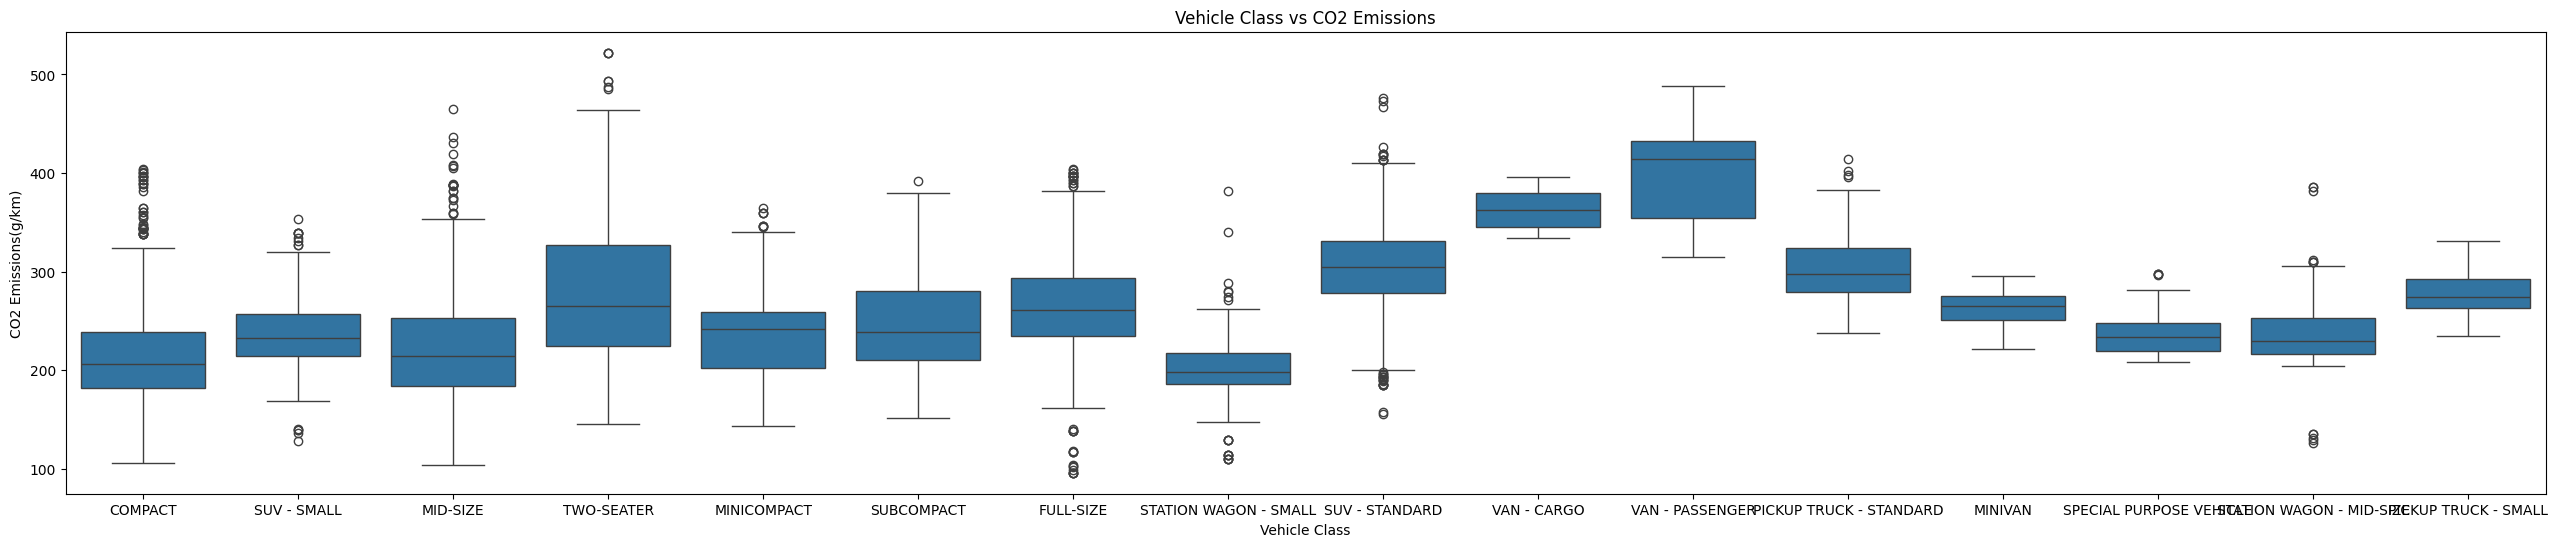

In [42]:
plt.figure(figsize=(32, 6))
sns.boxplot(data=df, x='Vehicle Class', y='CO2 Emissions(g/km)')
plt.title('Vehicle Class vs CO2 Emissions')
plt.show()

In [9]:
from sklearn.preprocessing import OneHotEncoder

print(df['Vehicle Class'].value_counts())
encoder =  OneHotEncoder(handle_unknown='ignore',sparse_output=False)
encoded_features = encoder.fit_transform(df[["Vehicle Class"]])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())
df= pd.concat([df.drop(["Vehicle Class"], axis=1), encoded_df], axis=1)

Vehicle Class
SUV - SMALL                 1217
MID-SIZE                    1133
COMPACT                     1022
SUV - STANDARD               735
FULL-SIZE                    639
SUBCOMPACT                   606
PICKUP TRUCK - STANDARD      538
TWO-SEATER                   460
MINICOMPACT                  326
STATION WAGON - SMALL        252
PICKUP TRUCK - SMALL         159
MINIVAN                       80
SPECIAL PURPOSE VEHICLE       77
VAN - PASSENGER               66
STATION WAGON - MID-SIZE      53
VAN - CARGO                   22
Name: count, dtype: int64


In [10]:
labelencoder = OrdinalEncoder(categories=[['X','Z','E','D','N']])
encoded_type = labelencoder.fit_transform(df[["Fuel Type"]])
df["Fuel Labels"] = encoded_type + 1 

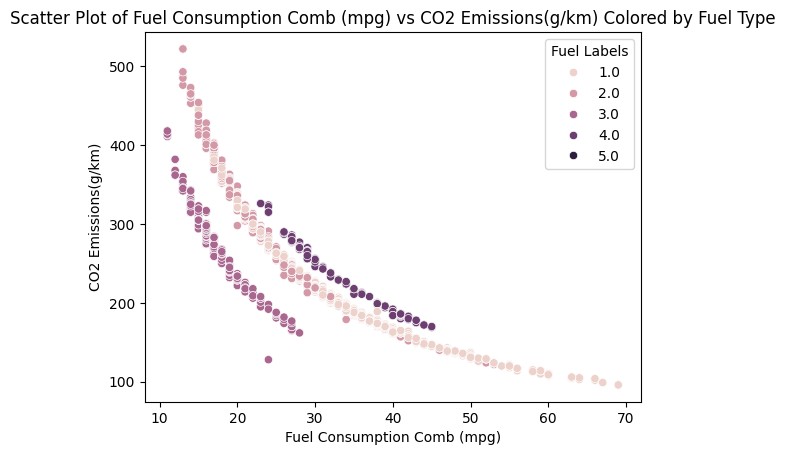

In [11]:
sns.scatterplot(data=df, x='Fuel Consumption Comb (mpg)', y='CO2 Emissions(g/km)', hue='Fuel Labels')
plt.title('Scatter Plot of Fuel Consumption Comb (mpg) vs CO2 Emissions(g/km) Colored by Fuel Type')
plt.show()

This new plot indicates 3 main categories. Fuel Type 3, 4 and 5 has relatively lowe emission compared to Fule Types 1 and 2. Also There should be a relation between Fuel Type and Fuel Consumption Comp. 

In [12]:
df.drop(['Make', 'Model', 'Transmission', 'Fuel Type'], axis=1, inplace=True)


In [13]:
print(df.columns)

Index(['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)',
       'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
       'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)',
       'Vehicle Class_COMPACT', 'Vehicle Class_FULL-SIZE',
       'Vehicle Class_MID-SIZE', 'Vehicle Class_MINICOMPACT',
       'Vehicle Class_MINIVAN', 'Vehicle Class_PICKUP TRUCK - SMALL',
       'Vehicle Class_PICKUP TRUCK - STANDARD',
       'Vehicle Class_SPECIAL PURPOSE VEHICLE',
       'Vehicle Class_STATION WAGON - MID-SIZE',
       'Vehicle Class_STATION WAGON - SMALL', 'Vehicle Class_SUBCOMPACT',
       'Vehicle Class_SUV - SMALL', 'Vehicle Class_SUV - STANDARD',
       'Vehicle Class_TWO-SEATER', 'Vehicle Class_VAN - CARGO',
       'Vehicle Class_VAN - PASSENGER', 'Fuel Labels'],
      dtype='object')


In [14]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('CO2 Emissions(g/km)', axis=1), df['CO2 Emissions(g/km)'], test_size=0.2, random_state=62)

In [15]:
model = LinearRegression()
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_pred = model.predict(x_test)

mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

print(f'Coefficient: {model.coef_}')
print(f'Intercept: {model.intercept_}')

Mean Squared Error: 264.40596620797197
R-squared: 0.9179139097183814
Coefficient: [  2.79167541   9.57589535   1.63860748   1.16947937   1.27961546
  -3.52790497  -6.71317672  -9.95761683  -8.06056558  -8.71921141
 -11.59021293  16.75589026  -4.09674923  -4.55414823  -7.25014696
  -4.89716689  -4.24530535  -2.86778731   2.91653304   2.55290418
   9.85383441  40.87292557  -5.49472595]
Intercept: 252.3293444899831


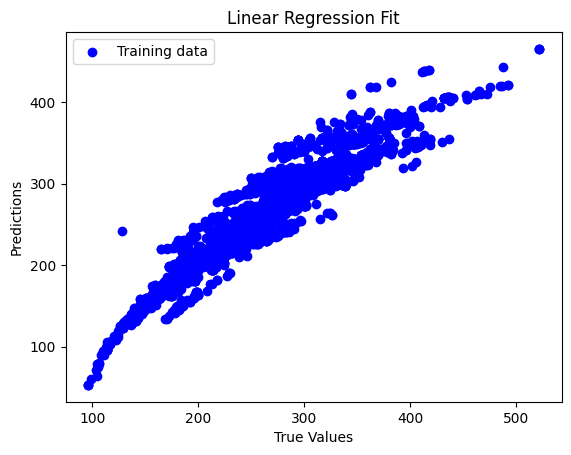

In [16]:

y_train_pred_sorted = sorted(list(zip(y_train, y_pred)))

plt.scatter(y_train,y_train_pred, color='blue', label='Training data')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Linear Regression Fit')
plt.legend()
plt.show()